In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fmin_cg, minimize
import h5py
c = 2.99792458e8   # m/s

In [2]:
def doppler(v):
    frac = (1. - v/c) / (1. + v/c)
    return np.sqrt(frac)

def gamma(v):
    return 1. / np.sqrt(1. - (v/c) ** 2)

def dlndopplerdv(v):
    dv = doppler(v)
    return -1. * gamma(v) / (2. * c) * (1. / dv  + dv)

def state(v, xs, xps):
    '''
    outputs: (M, Mp, v, xs, ms, mps, ehs, bees, seas)
    M and Mp are the lengths of data and model wavelength grids
    v is the RV
    xs is the wavelength values of the data grid
    ms is the data index m at which there is an interpolated model value
    mps is the model index m' from which we interpolate to ms
    ehs, bees, and seas go into the coefficients of interpolation
    '''
    # every input must be 1-d
    M = len(xs)
    Mp = len(xps)
    xps_shifted = xps + np.log(doppler(v))
    ms = np.arange(M)
    mps = np.searchsorted(xps_shifted, xs, side='left')
    good = (mps > 0) * (mps < Mp)
    ms = ms[good]
    mps = mps[good]
    ehs = xps_shifted[mps] - xs[ms]
    bees = xs[ms] - xps_shifted[mps - 1]
    seas = ehs + bees
    return (M, Mp, v, xs, ms, mps, ehs, bees, seas)

def Pdot(state, vec):
    # takes state and model flux vector, returns (shifted) model interpolated into data space
    # unpack state
    M, Mp, v, xs, ms, mps, ehs, bees, seas = state
    # do shit
    result = np.zeros(M)
    result[ms] = vec[mps - 1] * ehs / seas + vec[mps] * bees / seas
    return result

def dotP(state, vec):
    # takes state and data flux vector, returns data interpolated into (shifted) model space
    # unpack state
    M, Mp, v, xs, ms, mps, ehs, bees, seas = state
    # do shit
    result = np.zeros(Mp)
    result[mps - 1] += vec[ms] * ehs / seas
    result[mps] += vec[ms] * bees / seas
    return result

def dotdPdv(state, vec):
    # unpack state
    M, Mp, v, xs, ms, mps, ehs, bees, seas = state
    # do shit
    result = np.zeros(Mp)
    foos = vec[ms] / seas * dlndopplerdv(v) # * xs[ms] ??
    result[mps - 1] += foos
    result[mps] -= foos
    return result

def dPdotdv(state, vec):
    # unpack state
    M, Mp, v, xs, ms, mps, ehs, bees, seas = state
    # do shit
    result = np.zeros(M)
    result[ms] = (vec[mps - 1] - vec[mps]) * dlndopplerdv(v) / seas
    return result

In [3]:
f = h5py.File('../data/hip54287.hdf5', 'r')

N = 75
data = np.copy(f['data'])[:N,:]
data_xs = np.log(np.copy(f['xs']))
ivars = np.copy(f['ivars'])[:N,:]
true_rvs = np.copy(f['true_rvs'])[:N]
bervs = np.copy(f['berv'])[:N] * -1.e3

for i in xrange(len(data)):
    data[i] /= np.median(data[i])
    
data = np.log(data)

In [20]:
def make_template(all_data, rvs, xs, dx):
    """
    `all_data`: `[N, M]` array of pixels
    `rvs`: `[N]` array of RVs
    `xs`: `[M]` array of wavelength values
    `dx`: linear spacing desired for template wavelength grid (A)
    """
    (N,M) = np.shape(all_data)
    all_xs = np.empty_like(all_data)
    for i in range(N):
        all_xs[i,:] = xs - np.log(doppler(rvs[i])) # shift to rest frame
    all_data, all_xs = np.ravel(all_data), np.ravel(all_xs)
    tiny = 10.
    template_xs = np.arange(min(all_xs)-tiny*dx, max(all_xs)+tiny*dx, dx)
    template_ys = np.nan + np.zeros_like(template_xs)
    for i,t in enumerate(template_xs):
        ind = (all_xs >= t-dx/2.) & (all_xs < t+dx/2.)
        if np.sum(ind) > 0:
            template_ys[i] = np.nanmedian(all_data[ind])
    ind_nan = np.isnan(template_ys)
    template_ys.flat[ind_nan] = np.interp(template_xs[ind_nan], template_xs[~ind_nan], template_ys[~ind_nan]) #np.interp(template_xs[ind_nan], template_xs[~ind_nan], template_ys[~ind_nan])
    return template_xs, template_ys

def subtract_template(data_xs, data, model_xs_t, model_ys_t, rvs_t):
    (N,M) = np.shape(data)
    data_sub = np.copy(data)
    for n,v in enumerate(rvs_t):
        s = state(v, data_xs, model_xs_t)
        model_ys_t_shifted = Pdot(s, model_ys_t)
        data_sub[n,:] -= np.ravel(model_ys_t_shifted)
        if n == 0:
            plt.plot(data_xs, data[n,:], color='k')
            plt.plot(data_xs, data_sub[n,:], color='blue')
            plt.plot(data_xs, np.ravel(model_ys_t_shifted), color='red')
    return data_sub

In [5]:
x0_star = -np.copy(bervs)
x0_star -= np.mean(x0_star)
x0_t = np.zeros(N)
model_xs_star, model_ys_star = make_template(data, x0_star, data_xs, np.log(6000.01) - np.log(6000.))
model_xs_t, model_ys_t = make_template(data, x0_t, data_xs, np.log(6000.01) - np.log(6000.))

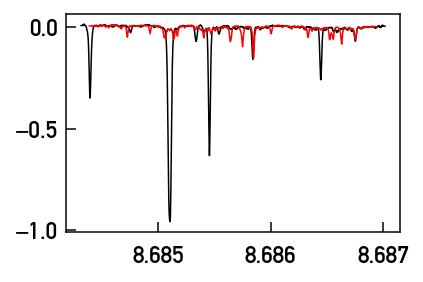

In [6]:
plt.plot(model_xs_star, model_ys_star, color='k')
plt.plot(model_xs_t, model_ys_t, color='red')
#plt.plot(data_xs, data[0,:], color='blue')

In [7]:
stepsize = 0.001
for n in range(75):
    tmp = np.copy(x0_star)
    s = state(tmp[n], data_xs, model_xs_star)
    ddotP1 = dotdPdv(s, data[n,:])
    tmp[n] += stepsize
    s = state(tmp[n], data_xs, model_xs_star)
    dotP0 = dotP(s, data[n,:])
    tmp[n] -= 2. * stepsize
    s = state(tmp[n], data_xs, model_xs_star)
    dotP2 = dotP(s, data[n,:])    
    print ddotP1[1000:1004]
    print (dotP0 - dotP2)[1000:1004]/(2 * stepsize)

[ -2.69414869e-05  -6.94456849e-06   2.71558932e-05   1.91587986e-05]
[ -2.69371981e-05  -6.94346298e-06   2.71515703e-05   1.91557487e-05]
[  1.08835211e-05  -1.58762189e-05  -3.85632344e-05   1.49649364e-05]
[  1.08846866e-05  -1.58779190e-05  -3.85673639e-05   1.49665388e-05]
[ -1.09399898e-05  -1.39728627e-05  -7.35531635e-06  -2.70795854e-06]
[ -1.09382482e-05  -1.39706383e-05  -7.35414546e-06  -2.70752746e-06]
[  1.21707276e-05  -1.82132346e-05   2.36035890e-06   1.03890811e-05]
[  1.21720309e-05  -1.82151849e-05   2.36061165e-06   1.03901935e-05]
[  4.69326451e-06  -7.87548860e-07  -5.49822535e-06  -5.91914654e-06]
[  4.69251741e-06  -7.87423494e-07  -5.49735011e-06  -5.91820430e-06]
[ -1.11401625e-05  -2.86261252e-05  -4.50569516e-06   2.34632785e-05]
[ -1.11383891e-05  -2.86215683e-05  -4.50497792e-06   2.34595435e-05]
[ -6.86534588e-06  -1.55065481e-05  -2.10916303e-05  -2.21527018e-05]
[ -6.86608104e-06  -1.55082086e-05  -2.10938889e-05  -2.21550740e-05]
[  1.97399748e-06  -

In [8]:
stepsize = 0.01
rv_steps = np.arange(0, 10, stepsize)
M = len(data[0,:])
Pdots = np.zeros((len(rv_steps), M))
dPdots = np.zeros((len(rv_steps), M))
for i in xrange(len(rv_steps)):
    drv = rv_steps[i]
    s = state(drv, data_xs, model_xs_star)
    Pdots[i,:] = Pdot(s, model_ys_star)
    dPdots[i,:] = dPdotdv(s, model_ys_star)
    
print (Pdots[-1] - Pdots[0])[1000:1004]
print (np.sum(dPdots*stepsize, axis=0))[1000:1004]

[  1.57089485e-05  -2.40025100e-05   3.77128655e-05   1.44735039e-05]
[  1.57246733e-05  -2.40265368e-05   3.77506165e-05   1.44879921e-05]


In [9]:
def rv_lnprior(rvs):
    return -0.5 * np.mean(rvs)**2/1.**2

def drv_lnprior_dv(rvs):
    return np.zeros_like(rvs) - np.mean(rvs)/1.**2/len(rvs)

def lnlike_star(rvs_star, rvs_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t):
    try:
        N = len(rvs_star)
    except:
        N = 1  
    lnlike = 0.
    dlnlike_dv = np.zeros(N)
    for n in range(N):
        state_star = state(rvs_star[n], data_xs, model_xs_star)
        pd_star = Pdot(state_star, model_ys_star)
        state_t = state(rvs_t[n], data_xs, model_xs_t)
        pd_t = Pdot(state_t, model_ys_t)
        pd = pd_star + pd_t
        lnlike += -0.5 * np.sum((data[n,:] - pd)**2 * ivars[n,:])
        dpd_dv = dPdotdv(state_star, model_ys_star)
        dlnlike_dv[n] = np.sum((data[n,:] - pd) * ivars[n,:] * dpd_dv)
    lnpost = lnlike + rv_lnprior(rvs_star)
    dlnpost_dv = dlnlike_dv + drv_lnprior_dv(rvs_star)
    return -1 * lnpost, -1 * dlnpost_dv

def lnlike_t(rvs_t, rvs_star, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t):
    try:
        N = len(rvs_t)
    except:
        N = 1  
    lnlike = 0.
    dlnlike_dv = np.zeros(N)
    for n in range(N):
        state_star = state(rvs_star[n], data_xs, model_xs_star)
        pd_star = Pdot(state_star, model_ys_star)
        state_t = state(rvs_t[n], data_xs, model_xs_t)
        pd_t = Pdot(state_t, model_ys_t)
        pd = pd_star + pd_t
        lnlike += -0.5 * np.sum((data[n,:] - pd)**2 * ivars[n,:])
        dpd_dv = dPdotdv(state_t, model_ys_t)
        dlnlike_dv[n] = np.sum((data[n,:] - pd) * ivars[n,:] * dpd_dv)
    lnpost = lnlike + rv_lnprior(rvs_t)
    dlnpost_dv = dlnlike_dv + drv_lnprior_dv(rvs_t)
    return -1 * lnpost, -1 * dlnpost_dv

In [10]:
print lnlike_star(x0_star, x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t)
print lnlike_star(true_rvs, x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t)

(443867.6785671917, array([-0.87910805, -0.1619633 , -4.51401912, -4.71766669, -0.90009856,
       -0.19824533, -1.20954629,  0.02018255, -0.99938244,  0.41831268,
        0.77227716,  0.94737996,  0.91713539,  0.35727079,  0.32425574,
       -0.86087292, -0.77795605, -0.76184418,  0.25432231, -0.11924608,
       -0.15891915,  0.55794609, -0.147008  ,  0.9849068 ,  1.19365293,
       -0.57464147, -0.0171348 ,  0.15305185,  0.09707713,  0.06284911,
       -0.34747223,  0.61407795, -0.53636073,  0.72579548, -2.00879154,
       -2.69445675,  0.60371669,  0.58900744,  0.71425305,  0.90561099,
       -0.55373991, -0.2243429 ,  0.45904055,  0.05294681,  1.41593872,
        0.0782868 , -0.67893733,  0.20556393,  0.4219801 ,  0.736875  ,
        0.42665224,  0.82496428,  0.02509037,  0.43471543, -2.01852413,
       -2.29408248, -2.42152862, -1.13682841, -0.66191128,  0.35960118,
        0.32638424,  0.61371447,  0.00694899,  0.51962859,  0.41320101,
       -0.02657668, -1.64806063, -1.83825373

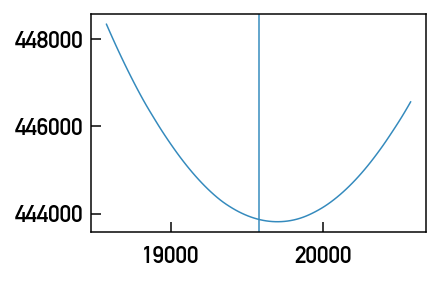

In [11]:
test_rvs = np.linspace(-1.e3+x0_star[0], 1.e3+x0_star[0], 100)
chisq = np.zeros_like(test_rvs)
for i,v in enumerate(test_rvs):
    tmp = np.copy(x0_star)
    tmp[0] = v
    lnlike0, dlnlike_dv0 = lnlike_star(tmp, x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t)
    chisq[i] = lnlike0
    
plt.plot(test_rvs, chisq)
plt.axvline(x0_star[0])

In [12]:
stepsize = 0.001
lnlike1, dlnlike_dv1 = lnlike_star(x0_star, x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t)
for n in range(75):
    tmp = np.copy(x0_star)
    tmp[n] += stepsize
    lnlike0, dlnlike_dv0 = lnlike_star(tmp, x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t)
    tmp[n] -= 2. * stepsize
    lnlike2, dlnlike_dv2 = lnlike_star(tmp, x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t)
    print dlnlike_dv1[n]
    print (lnlike0 - lnlike2)/(2 * stepsize)

-0.87910804999
-0.87896810146
-0.161963302813
-0.16198065714
-4.51401912282
-4.51330054784
-4.71766669299
-4.71817186917
-0.900098560144
-0.899955281056
-0.19824532872
-0.198213761905
-1.20954629335
-1.20967582916
0.0201825500319
0.0201847287826
-0.999382436614
-0.999489449896
0.418312679852
0.41835749289
0.772277155417
0.772359868279
0.947379963951
0.947229156736
0.917135392113
0.917233614018
0.357270792443
0.35730903619
0.324255736322
0.324290449498
-0.86087291639
-0.860735890456
-0.777956051149
-0.778039364377
-0.761844179345
-0.76192576671
0.254322314127
0.254349550232
-0.119246078296
-0.119258853374
-0.158919146041
-0.15889381757
0.55794608888
0.558005820494
-0.147008003934
-0.147023733007
0.984906800961
0.9850122442
1.19365292585
1.19346292922
-0.574641469373
-0.574703008169
-0.017134798029
-0.0171366264112
0.15305184597
0.153068220243
0.0970771299176
0.0970616820268
0.0628491090692
0.0628503912594
-0.347472232019
-0.347509427229
0.614077947524
0.614143704297
-0.536360726272
-0.5

In [13]:
stepsize = 0.001
lnlike1, dlnlike_dv1 = lnlike_t(x0_t, x0_star, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t)
for n in range(75):
    tmp = np.copy(x0_t)
    tmp[n] += stepsize
    lnlike0, dlnlike_dv0 = lnlike_t(tmp, x0_star, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t)
    tmp[n] -= 2. * stepsize
    lnlike2, dlnlike_dv2 = lnlike_t(tmp, x0_star, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t)
    print dlnlike_dv1[n]
    print (lnlike0 - lnlike2)/(2 * stepsize)

-0.0176042673085
-0.017605809262
-0.0127509277187
-0.0127514067572
0.23001198461
0.230032339459
0.0986525211528
0.098653632449
-0.149211784488
-0.149237719597
-0.0481950948015
-0.048200978199
0.158361759093
0.158371723955
0.191652325441
0.191667029867
0.0885830974417
0.0885874324013
0.079882587305
0.0798908004072
-0.0834039051116
-0.0834140519146
0.0850687635977
0.0850785581861
-0.152208797979
-0.152226071805
-0.0820953321095
-0.0821056892164
-0.0602758991428
-0.0602833752055
-0.192269536399
-0.192304782104
-0.11751967885
-0.117534218589
0.0205253986043
0.0205193355214
0.194453370224
0.194469816051
0.40023603699
0.400266057113
0.0609940341352
0.0609985436313
-0.0162487916556
-0.0162526266649
-0.123480332959
-0.123500736663
-0.0685126102419
-0.0685202830937
-0.115218496302
-0.115237402497
-0.0109103279118
-0.0109147222247
0.112929442842
0.112940208055
0.140308106008
0.140323012602
0.217414824879
0.217438937398
0.115863684865
0.115868664579
0.148558227063
0.148570921738
0.184976049233
0.

In [14]:
soln_star =  minimize(lnlike_star, x0_star, args=(x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t),
                     method='BFGS', jac=True, options={'disp':True, 'gtol':1.e-2, 'eps':1.5e-5})['x']
print np.std(soln_star + true_rvs)

Optimization terminated successfully.
         Current function value: 442225.910594
         Iterations: 38
         Function evaluations: 42
         Gradient evaluations: 42
39.3385130392


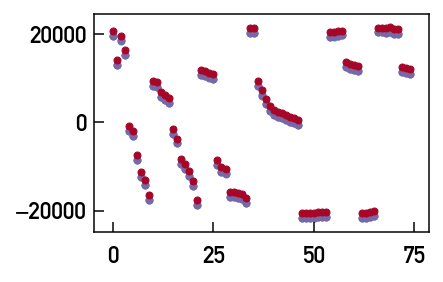

In [15]:
plt.scatter(np.arange(N), x0_star)
plt.scatter(np.arange(N), soln_star)
plt.scatter(np.arange(N), -true_rvs)

In [16]:
print soln_star - x0_star

[ 114.76430746   11.25477782   87.79822688   87.50468157   23.36538073
    8.48561962   22.37848962   -4.54298607   31.68493749  -33.43285247
  -33.70699836  -68.53317395  -30.48621895  -30.69378104  -32.29912649
   15.19706913   31.23033539   22.84232063   -7.76151647    0.59842161
    4.00791818  -16.76011663    1.91279756  -46.18832346  -35.65123106
   16.45760394   -3.98517378  -12.61823388   -8.75195115   -3.32384804
   10.12739115  -16.36208638   12.03742418  -37.25632186   76.78338229
   73.67775924  -29.86697509  -40.70007429  -37.01749142  -27.20910981
   17.9596887     6.40372618  -17.64442825   -6.47598366  -60.84500817
   -5.51181493   17.40040778  -14.90788961  -17.0640039   -22.05854044
  -17.76347352  -22.29056421   -7.45718769  -18.85481965   78.33085338
   86.90215648   82.6132118    46.9615319    24.58593248  -21.10299314
  -20.4679791   -33.91233161  -11.16331472  -33.37194124  -14.26558031
   -3.45375288   58.25329299   88.92819745   61.71499741   62.88584798
   33.

In [17]:
soln_star =  minimize(lnlike_star, x0_star, args=(x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t),
                     method='BFGS', jac=True, options={'disp':True, 'gtol':1.e-2, 'eps':1.5e-5})['x']
soln_t =  minimize(lnlike_t, x0_t, args=(soln_star, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t),
                     method='BFGS', jac=True, options={'disp':True, 'gtol':1.e-2, 'eps':1.5e-5})['x']

x0_star = soln_star
x0_t = soln_t
print np.std(x0_star + true_rvs)
print np.std(x0_t)

Optimization terminated successfully.
         Current function value: 442225.910594
         Iterations: 38
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 441862.782898
         Iterations: 86
         Function evaluations: 102
         Gradient evaluations: 102
39.3385130392
70.3270328249


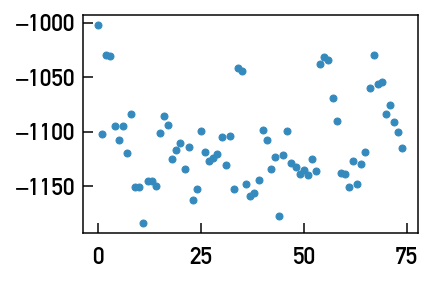

In [18]:
plt.scatter(np.arange(N), soln_star + true_rvs)

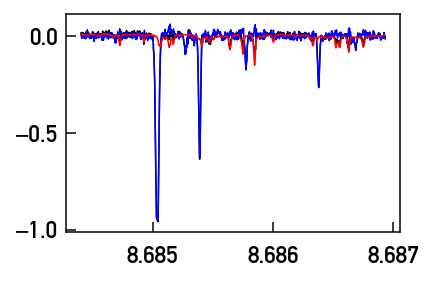

In [21]:
data_star = subtract_template(data_xs, data, model_xs_t, model_ys_t, x0_t)

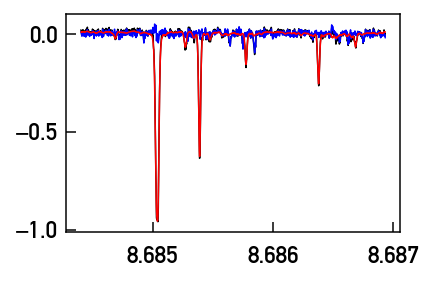

In [22]:
data_t = subtract_template(data_xs, data, model_xs_star, model_ys_star, x0_star)

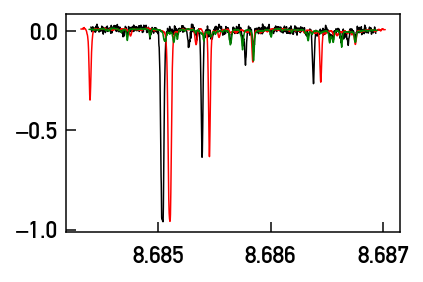

In [23]:
plt.plot(data_xs, data[0,:], color='black')
plt.plot(model_xs_star, model_ys_star, color='red')
plt.plot(model_xs_t, model_ys_t, color='green')

In [24]:
soln_star =  minimize(lnlike_star, x0_star, args=(x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t),
                     method='BFGS', jac=True, options={'disp':True, 'gtol':1.e-2, 'eps':1.5e-5})['x']
soln_t =  minimize(lnlike_t, x0_t, args=(soln_star, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t),
                     method='BFGS', jac=True, options={'disp':True, 'gtol':1.e-2, 'eps':1.5e-5})['x']


print np.std(soln_star + true_rvs)
print np.std(soln_t)

Optimization terminated successfully.
         Current function value: 441882.441254
         Iterations: 12
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 441862.223426
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
29508.5418851
70.3270328249


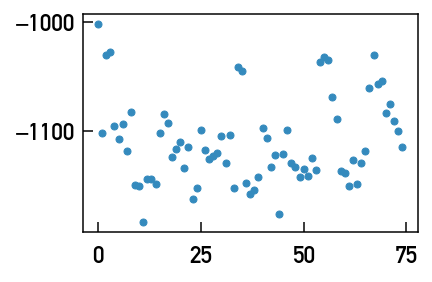

In [25]:
plt.scatter(np.arange(N), soln_star + true_rvs)

Optimization terminated successfully.
         Current function value: 405892.849556
         Iterations: 38
         Function evaluations: 42
         Gradient evaluations: 42
         Current function value: 405483.827292
         Iterations: 329
         Function evaluations: 436
         Gradient evaluations: 429
iter 0: star std = 19.05, telluric std = 71.08


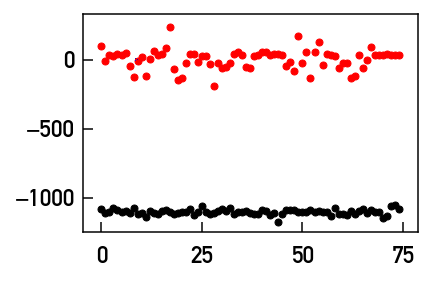

Optimization terminated successfully.
         Current function value: 359892.157410
         Iterations: 20
         Function evaluations: 24
         Gradient evaluations: 24
         Current function value: 359708.475854
         Iterations: 162
         Function evaluations: 232
         Gradient evaluations: 228
iter 1: star std = 20.61, telluric std = 68.01


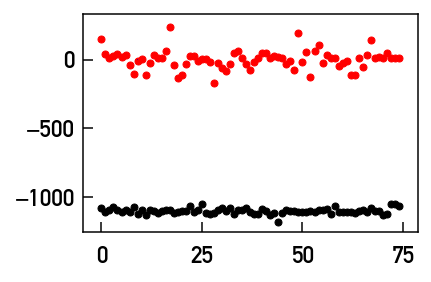

         Current function value: 378036.460439
         Iterations: 78
         Function evaluations: 106
         Gradient evaluations: 96
         Current function value: 377793.836083
         Iterations: 232
         Function evaluations: 324
         Gradient evaluations: 318
iter 2: star std = 20.83, telluric std = 73.55


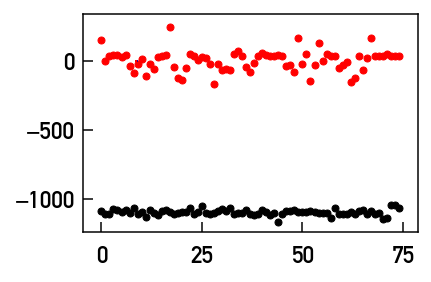

Optimization terminated successfully.
         Current function value: 349820.108799
         Iterations: 20
         Function evaluations: 23
         Gradient evaluations: 23
         Current function value: 349602.399153
         Iterations: 42
         Function evaluations: 101
         Gradient evaluations: 97
iter 3: star std = 20.90, telluric std = 74.02


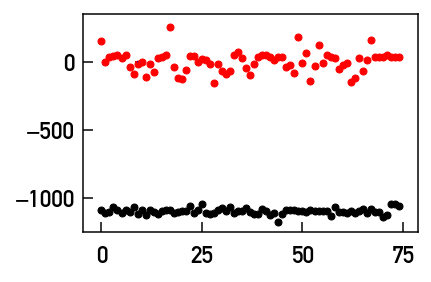

Optimization terminated successfully.
         Current function value: 368420.758526
         Iterations: 31
         Function evaluations: 34
         Gradient evaluations: 34
         Current function value: 368176.635339
         Iterations: 229
         Function evaluations: 317
         Gradient evaluations: 314
iter 4: star std = 21.27, telluric std = 75.01


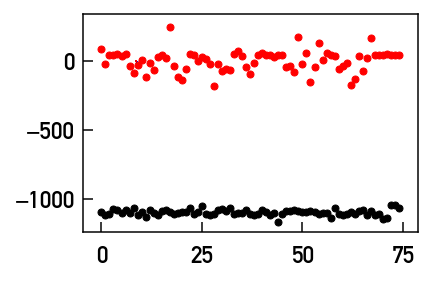

In [26]:
for n in range(5):
    x0_star = soln_star
    x0_t = soln_t

    data_star = subtract_template(data_xs, data, model_xs_t, model_ys_t, x0_t)
    data_t = subtract_template(data_xs, data, model_xs_star, model_ys_star, x0_star)

    model_xs_star, model_ys_star = make_template(data_star, x0_star, data_xs, np.log(6000.01) - np.log(6000.))
    model_xs_t, model_ys_t = make_template(data_t, x0_t, data_xs, np.log(6000.01) - np.log(6000.))

    soln_star =  minimize(lnlike_star, x0_star, args=(x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t),
                     method='BFGS', jac=True, options={'disp':True, 'gtol':1.e-2, 'eps':1.5e-5})['x']
    soln_t =  minimize(lnlike_t, x0_t, args=(soln_star, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t),
                     method='BFGS', jac=True, options={'disp':True, 'gtol':1.e-2, 'eps':1.5e-5})['x']

    print "iter {0}: star std = {1:.2f}, telluric std = {2:.2f}".format(n, np.std(soln_star + true_rvs), np.std(soln_t))
    plt.scatter(np.arange(N), soln_star + true_rvs, color='k')
    plt.scatter(np.arange(N), soln_t, color='red')
    plt.show()


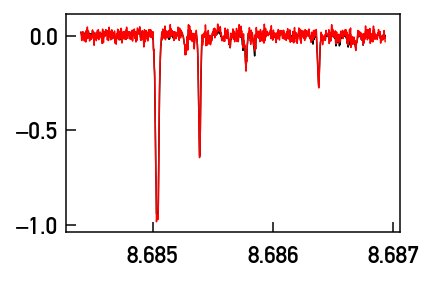

In [27]:
plt.plot(data_xs, data[0,:], color='k')
plt.plot(data_xs, data_star[0,:] + data_t[0,:], color='red')

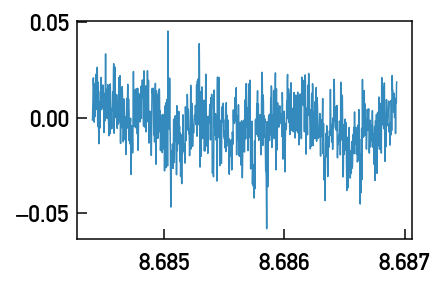

In [28]:
plt.plot(data_xs, data[0,:] - data_star[0,:] - data_t[0,:])

(array([   1.,   11.,   58.,  144.,  357.,  497.,  311.,  111.,    8.,    2.]),
 array([-0.05822071, -0.04785908, -0.03749746, -0.02713583, -0.0167742 ,
        -0.00641257,  0.00394906,  0.01431069,  0.02467231,  0.03503394,
         0.04539557]),
 <a list of 10 Patch objects>)

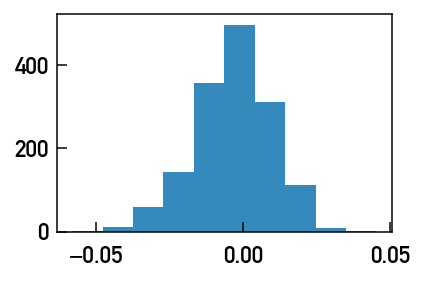

In [29]:
plt.hist(data[0,:] - data_star[0,:] - data_t[0,:])